<a href="https://colab.research.google.com/github/JiihwanKim/Quantum_Information_Processing/blob/master/MinErrorDiscrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimum Error Discrimination
 MinErrorDiscrimination Calculates guessing probability and optimals
 
 This function has three required arguments:
 
    q: prior probability list (1xN)
    
    RHO: density operators(dxd array)'s list (1xN)
    
    precision: number (1x1)
    
 Pg,M,K = MinErrorDiscrimination(q,RHO,precision) calculates guessing
 
 probability(Pg), optimal measurement(M) and symmetry operator(K).
 
 Requires: cvxpy, numpy
 
 Author: Jihwan Kim (mslab.k@gmail.com )
 
 Affiliation: Mathematical Science Lab, Applied Physics, Hanyang University, South Korea
 
 Last updated: Dec. 9, 2020

## (code) SDP optimization for MD

**Start from the dual**

In [ ]:
%reset -f
# Minimum Error Discrimination from Dual Problem

def MinErrorDiscriminationDual(q,RHO,precision):
  if isinstance(q,list) and isinstance(RHO,list) and len(q)==len(RHO):
    import cvxpy as cp
    num_of_states = len(RHO)
    
    # Construction of the problem.
    K = cp.Variable((len(RHO[1]),len(RHO[1])),hermitian=True);
    objective = cp.Minimize(cp.real(cp.trace(K)));
    constraints = [K-q[x]*RHO[x]>>0 for x in range(num_of_states)];
    prob = cp.Problem(objective, constraints);
    prob.solve(solver=cp.SCS)
    
    # Return the optimals.
    Pg = objective.value
    K = np.around(K.value,precision)

    return  Pg, K
  
  else: raise ValueError("Unknown format")

**Start from the primal**

In [ ]:
# Minimum Error Discrimination from Primal Problem

def MinErrorDiscrimination(q,RHO,precision):
  if isinstance(q,list) and isinstance(RHO,list) and len(q)==len(RHO):
    def Correct_Probability(q,RHO,M):
      return cp.sum([cp.real(cp.trace(q[x]*RHO[x]*M[x])) for x in range(num_of_states)])
    import cvxpy as cp
    num_of_states = len(RHO)
    # Construction of the problem.
    M = [cp.Variable((len(RHO[0]),len(RHO[0])),hermitian=True) for x in range(num_of_states)];
    objective = cp.Maximize(Correct_Probability(q,RHO,M));
    constraints = [M[x]>>0 for x in range(num_of_states)]+[cp.sum(M)==np.eye(len(RHO[0]))];
    prob = cp.Problem(objective, constraints);
    prob.solve(solver=cp.SCS)
    
#   Return the optimals.
    K = np.around(constraints[-1].dual_value,precision)
    K = constraints[-1].dual_value
    Pg = objective.value
    M = [np.around(M[x].value,precision) for x in range(len(M))]
    return Pg,M,K
  
  else: raise ValueError("Unknown format")


## Example


### Simple example
Suppose that the given states are prepared in a system with equiprobably.
<p align="center">
$\rho_0 = \pmatrix{1&0\\ 0&0}$,&nbsp;&nbsp;&nbsp;  $\rho_1 = \frac{1}{2}\pmatrix{1&1\\ 1&1}$,&nbsp;&nbsp;&nbsp; $\rho_2 = \frac{1}{2}\pmatrix{1&0\\ 0&1}$
</p>
Find a optimal measurement providing guessing probability.

In [ ]:
import numpy as np
q = [1/3,1/3,1/3];
RHO = [np.array([[1, 0],[0, 0]])]
RHO.append(np.array([[1, 1],[1, 1]])*0.5)
RHO.append(np.array([[1, 0],[0, 1]])*0.5)
Pg,M,K = MinErrorDiscrimination(q,RHO,3)

### Minimizing the number to be discriminated

In [ ]:
w = 0.5
N = 10
f = [1,2,3,4,5]
RHO = np.matrix([[w/2+(1-w)/3,w/2,0],[w/2,w/2+(1-w)/3,0],[0,0,(1-w)/3]])
U = np.matrix([[np.exp(2*np.pi*1j*f[0]/N),0,0],[0,np.exp(2*np.pi*1j*f[1]/N),0],[0,0,np.exp(2*np.pi*1j*f[2]/N)]])
DensityOperators = [U**k*RHO*U.H**k for k in range(N)]

In [ ]:
q = [1/N]*N
Pg,M,K = MinErrorDiscrimination(q,DensityOperators,6)

In [ ]:
Z = [[1,2,2,2,2],
     [1,2*np.cos(2*np.pi*(f[0]-f[1])*1/N),2*np.cos(2*np.pi*(f[0]-f[1])*2/N),2*np.cos(2*np.pi*(f[0]-f[1])*3/N),2*np.cos(2*np.pi*(f[0]-f[1])*4/N)],
     [1,2*np.cos(2*np.pi*(f[0]-f[2])*1/N),2*np.cos(2*np.pi*(f[0]-f[2])*2/N),2*np.cos(2*np.pi*(f[0]-f[2])*3/N),2*np.cos(2*np.pi*(f[0]-f[2])*4/N)],
     [1,2*np.cos(2*np.pi*(f[0]-f[3])*1/N),2*np.cos(2*np.pi*(f[0]-f[3])*2/N),2*np.cos(2*np.pi*(f[0]-f[3])*3/N),2*np.cos(2*np.pi*(f[0]-f[3])*4/N)],
     [1,2*np.cos(2*np.pi*(f[0]-f[4])*1/N),2*np.cos(2*np.pi*(f[0]-f[4])*2/N),2*np.cos(2*np.pi*(f[0]-f[4])*3/N),2*np.cos(2*np.pi*(f[0]-f[4])*4/N)]]

In [ ]:
np.linalg.det(np.matrix(Z))

99.99999999999996

In [ ]:
P = np.linalg.inv(Z)*np.matrix([[1],[0],[0],[0],[0]])
P = np.append(np.array(P),0)
d = len(RHO)
L = [np.matrix(np.array(P)[min(k,10-k)]*d/np.trace(M[k])*M[k]) for k in range(10)]
print(1/N*(DensityOperators[0]*L[0]+DensityOperators[2]*L[2]+DensityOperators[4]*L[4]+DensityOperators[6]*L[6]+DensityOperators[8]*L[8]))
print(K)

[[ 6.66666328e-02+1.56125113e-18j -8.11814524e-08+8.32667268e-18j
   0.00000000e+00+0.00000000e+00j]
 [-8.11814524e-08+0.00000000e+00j  6.66666328e-02-1.73472348e-18j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.66666445e-02+2.77544654e-19j]]
[[ 6.66666316e-02+0.00000000e+00j -1.25192166e-12-3.14776214e-12j
   2.32176824e-19-1.32339959e-18j]
 [-1.25192166e-12+3.14776214e-12j  6.66666316e-02+0.00000000e+00j
   7.09307677e-19-7.54326824e-19j]
 [ 2.32176824e-19+1.32339959e-18j  7.09307677e-19+7.54326824e-19j
   1.66666878e-02+0.00000000e+00j]]


In [ ]:
from itertools import permutations
from collections import OrderedDict
def den2vec(rho): 
  n = len(np.array(rho))
  Standard_Basis = list(OrderedDict((x,None) for x in permutations([1]+[0]*(n-1))))
  B = [np.array([Standard_Basis[x]]).T for x in range(n)]
  E = [[np.dot(B[x],B[y].T) for y in range(n)] for x in range(n)]
  S = [E[x][y]+E[y][x] for y in range(n) if y is not 0 for x in range(y) ]
  A = [-1j*(E[x][y]-E[y][x]) for y in range(n) if y is not 0 for x in range(y) ]
  D = [np.sqrt(2/((l+2)*(l+1)))*(np.sum([E[x][x] for x in range(l+1)],0)-(l+1)*E[l+1][l+1]) for l in range(n-1)]
  Lambda = S+A+D # Genalized Gell-Mann Matrices, arXiv:1705.01523v3
  return np.real([np.sqrt(n/(2*(n-1)))*np.trace(np.dot(rho,Lambda[x])) for x in range(n**2-1)])

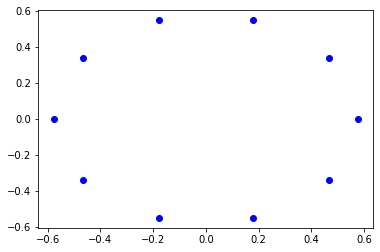

In [ ]:
x = [[den2vec(M[k]/np.trace(M[k])) for k in range(N)][l][0] for l in range(N)]
y = [[den2vec(M[k]/np.trace(M[k])) for k in range(N)][l][3] for l in range(N)]
from matplotlib import pyplot as plt
plt.plot(x,y,'bo')
plt.show()

In [ ]:
!pip install qutip

In [ ]:
import numpy as np
import qutip as qt
q = [1/5,1/2,3/10];
RHO = [np.array(qt.rand_ket(3).proj())]
RHO.append(np.array(qt.rand_ket(3).proj()))
RHO.append(np.array(qt.rand_ket(3).proj()))
Pg,M,K = MinErrorDiscrimination(q,RHO,3)
Pg
M

[array([[ 0.551+0.j   , -0.22 +0.189j, -0.377-0.147j],
        [-0.22 -0.189j,  0.152+0.j   ,  0.1  +0.187j],
        [-0.377+0.147j,  0.1  -0.187j,  0.296+0.j   ]]),
 array([[ 0.05 +0.j   , -0.12 -0.113j,  0.032+0.138j],
        [-0.12 +0.113j,  0.544+0.j   , -0.391-0.26j ],
        [ 0.032-0.138j, -0.391+0.26j ,  0.406+0.j   ]]),
 array([[0.399+0.j   , 0.34 -0.076j, 0.344+0.009j],
        [0.34 +0.076j, 0.304+0.j   , 0.292+0.073j],
        [0.344-0.009j, 0.292-0.073j, 0.297+0.j   ]])]